In [1]:
from functools import partial
import graphviz

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pytensor
import pytensor.tensor as pt
import scipy.stats

import pymc as pm

In [3]:
x = pt.scalar(name="x")
y = pt.vector(name="y")

print(
    f"""
x type: {x.type}
x name = {x.name}
---
y type: {y.type}
y name = {y.name}
"""
)


x type: Scalar(float64, shape=())
x name = x
---
y type: Vector(float64, shape=(?,))
y name = y



In [4]:
z = x + y
z.name = "x + y"

In [5]:
w = pt.log(z)
w.name = "log(x + y)"

In [6]:
pytensor.dprint(w)

Log [id A] 'log(x + y)'
 └─ Add [id B] 'x + y'
    ├─ ExpandDims{axis=0} [id C]
    │  └─ x [id D]
    └─ y [id E]


In [7]:
f = pytensor.function(inputs=[x, y], outputs=w)

In [8]:
f(x=0, y=[1, np.e])

array([0., 1.])

In [9]:
w.eval({x: 0, y: [1, np.e]})

array([0., 1.])

In [10]:
a = pt.scalar(name="a")
b = pt.scalar(name="b")

c = a / b
c.name = "a / b"

pytensor.dprint(c)

True_div [id A] 'a / b'
 ├─ a [id B]
 └─ b [id C]


In [11]:
d = b * c
d.name = "b * c"

pytensor.dprint(d)

Mul [id A] 'b * c'
 ├─ b [id B]
 └─ True_div [id C] 'a / b'
    ├─ a [id D]
    └─ b [id B]


In [12]:
g = pytensor.function(inputs=[a, b], outputs=d)

pytensor.dprint(g)

DeepCopyOp [id A] 0
 └─ a [id B]


In [13]:
print(
    f"""
z type: {z.type}
z name = {z.name}
z owner = {z.owner}
z owner inputs = {z.owner.inputs}
z owner op = {z.owner.op}
z owner output = {z.owner.outputs}
"""
)


z type: Vector(float64, shape=(?,))
z name = x + y
z owner = Add(ExpandDims{axis=0}.0, y)
z owner inputs = [ExpandDims{axis=0}.0, y]
z owner op = Add
z owner output = [x + y]



In [14]:
# start from the top
stack = [w]

while stack:
    print("---")
    var = stack.pop(0)
    print(f"Checking variable {var} of type {var.type}")
    # check variable is not a root variable
    if var.owner is not None:
        print(f" > Op is {var.owner.op}")
        # loop over the inputs
        for i, input in enumerate(var.owner.inputs):
            print(f" > Input {i} is {input}")
            stack.append(input)
    else:
        print(f" > {var} is a root variable")

---
Checking variable log(x + y) of type Vector(float64, shape=(?,))
 > Op is Log
 > Input 0 is x + y
---
Checking variable x + y of type Vector(float64, shape=(?,))
 > Op is Add
 > Input 0 is ExpandDims{axis=0}.0
 > Input 1 is y
---
Checking variable ExpandDims{axis=0}.0 of type Vector(float64, shape=(1,))
 > Op is ExpandDims{axis=0}
 > Input 0 is x
---
Checking variable y of type Vector(float64, shape=(?,))
 > y is a root variable
---
Checking variable x of type Scalar(float64, shape=())
 > x is a root variable


In [15]:
pytensor.dprint(w)

Log [id A] 'log(x + y)'
 └─ Add [id B] 'x + y'
    ├─ ExpandDims{axis=0} [id C]
    │  └─ x [id D]
    └─ y [id E]


In [16]:
# get input tensors
list(pytensor.graph.graph_inputs(graphs=[w]))

[y, x]

In [17]:
parent_of_w = w.owner.inputs[0]  # get z tensor
new_parent_of_w = pt.exp(parent_of_w)  # modify the parent of w
new_parent_of_w.name = "exp(x + y)"

In [18]:
pytensor.dprint(w)

Log [id A] 'log(x + y)'
 └─ Add [id B] 'x + y'
    ├─ ExpandDims{axis=0} [id C]
    │  └─ x [id D]
    └─ y [id E]


In [19]:
new_w = pytensor.clone_replace(output=[w], replace={parent_of_w: new_parent_of_w})[0]
new_w.name = "log(exp(x + y))"
pytensor.dprint(new_w)

Log [id A] 'log(exp(x + y))'
 └─ Exp [id B] 'exp(x + y)'
    └─ Add [id C] 'x + y'
       ├─ ExpandDims{axis=0} [id D]
       │  └─ x [id E]
       └─ y [id F]


In [20]:
new_w.eval({x: 0, y: [1, np.e]})

array([1.        , 2.71828183])

In [21]:
f = pytensor.function(inputs=[x, y], outputs=new_w)

pytensor.dprint(f)

Add [id A] 'x + y' 1
 ├─ ExpandDims{axis=0} [id B] 0
 │  └─ x [id C]
 └─ y [id D]


In [22]:
f(x=0, y=[1, np.e])

array([1.        , 2.71828183])

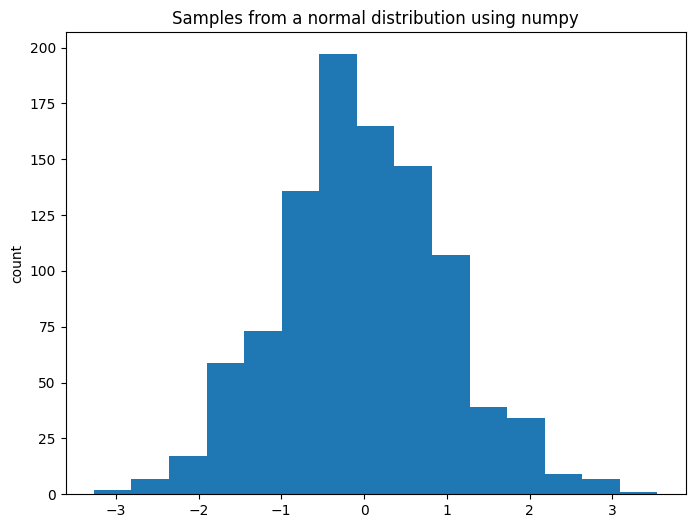

In [23]:
a = np.random.normal(loc=0, scale=1, size=1_000)

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(a, color="C0", bins=15)
ax.set(title="Samples from a normal distribution using numpy", ylabel="count");

In [24]:
y = pt.random.normal(loc=0, scale=1, name="y")
y.type

TensorType(float64, shape=())

In [25]:
pytensor.dprint(y)

normal_rv{"(),()->()"}.1 [id A] 'y'
 ├─ RNG(<Generator(PCG64) at 0x7F27B0C8AA40>) [id B]
 ├─ NoneConst{None} [id C]
 ├─ 0 [id D]
 └─ 1 [id E]


In [26]:
y.eval()

array(1.3660433)

In [27]:
for i in range(10):
    print(f"Sample {i}: {y.eval()}")

Sample 0: 1.3660432997222753
Sample 1: 1.3660432997222753
Sample 2: 1.3660432997222753
Sample 3: 1.3660432997222753
Sample 4: 1.3660432997222753
Sample 5: 1.3660432997222753
Sample 6: 1.3660432997222753
Sample 7: 1.3660432997222753
Sample 8: 1.3660432997222753
Sample 9: 1.3660432997222753


In [28]:
x = pm.Normal.dist(mu=0, sigma=1)
pytensor.dprint(x)

normal_rv{"(),()->()"}.1 [id A]
 ├─ RNG(<Generator(PCG64) at 0x7F27B0C8AB20>) [id B]
 ├─ NoneConst{None} [id C]
 ├─ 0 [id D]
 └─ 1 [id E]


In [29]:
for i in range(10):
    print(f"Sample {i}: {x.eval()}")

Sample 0: 1.6539013998741592
Sample 1: 1.6539013998741592
Sample 2: 1.6539013998741592
Sample 3: 1.6539013998741592
Sample 4: 1.6539013998741592
Sample 5: 1.6539013998741592
Sample 6: 1.6539013998741592
Sample 7: 1.6539013998741592
Sample 8: 1.6539013998741592
Sample 9: 1.6539013998741592


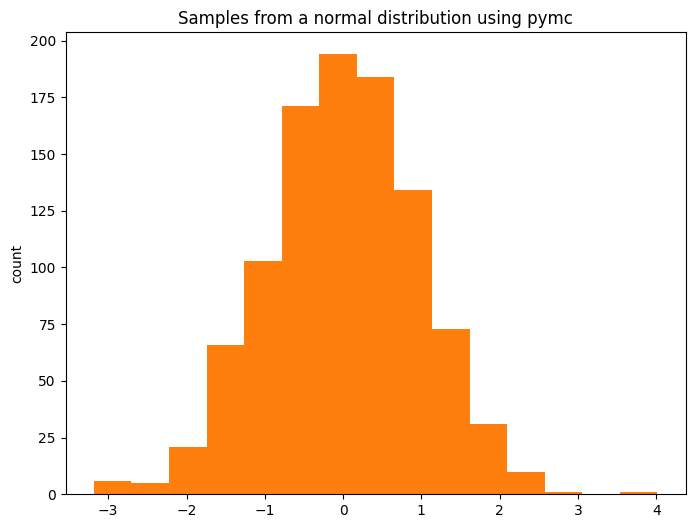

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(pm.draw(x, draws=1_000), color="C1", bins=15)
ax.set(title="Samples from a normal distribution using pymc", ylabel="count");

In [31]:
with pm.Model() as model:
    z = pm.Normal(name="z", mu=np.array([0, 0]), sigma=np.array([1, 2]))

pytensor.dprint(z)

normal_rv{"(),()->()"}.1 [id A] 'z'
 ├─ RNG(<Generator(PCG64) at 0x7F27AEA08BA0>) [id B]
 ├─ NoneConst{None} [id C]
 ├─ [0 0] [id D]
 └─ [1 2] [id E]


In [32]:
model.basic_RVs

[z ~ Normal(<constant>, <constant>)]

In [33]:
for i in range(10):
    print(f"Sample {i}: {z.eval()}")

Sample 0: [-0.66075999  2.76852675]
Sample 1: [-0.66075999  2.76852675]
Sample 2: [-0.66075999  2.76852675]
Sample 3: [-0.66075999  2.76852675]
Sample 4: [-0.66075999  2.76852675]
Sample 5: [-0.66075999  2.76852675]
Sample 6: [-0.66075999  2.76852675]
Sample 7: [-0.66075999  2.76852675]
Sample 8: [-0.66075999  2.76852675]
Sample 9: [-0.66075999  2.76852675]


In [34]:
for i in range(10):
    print(f"Sample {i}: {pm.draw(z)}")

Sample 0: [-0.86698071  1.65603185]
Sample 1: [0.12277398 2.32070155]
Sample 2: [-0.05198923  5.35108416]
Sample 3: [0.58836498 0.07015382]
Sample 4: [-1.36497739 -0.45362256]
Sample 5: [ 0.64387487 -0.89872892]
Sample 6: [-0.07090403  0.60078694]
Sample 7: [ 1.05219915 -2.17215724]
Sample 8: [-0.42505451  1.52034723]
Sample 9: [-0.79241454  0.46378542]


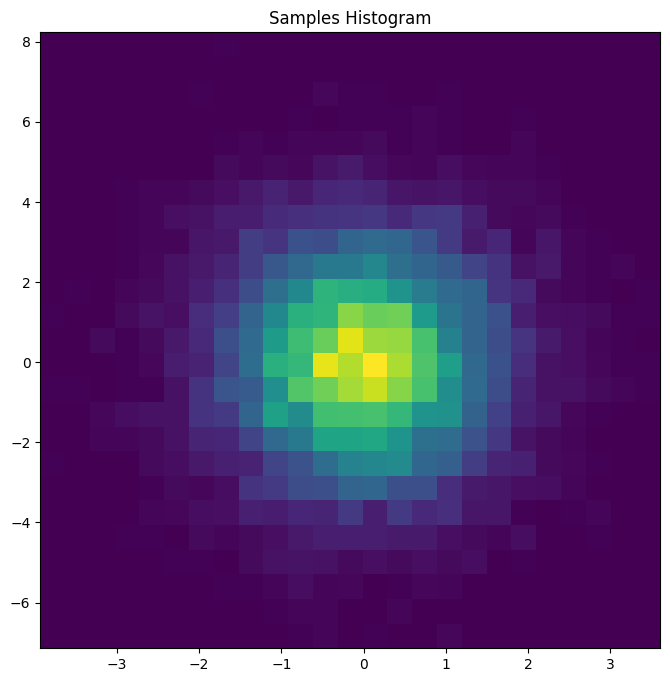

In [35]:
fig, ax = plt.subplots(figsize=(8, 8))
z_draws = pm.draw(vars=z, draws=10_000)
ax.hist2d(x=z_draws[:, 0], y=z_draws[:, 1], bins=25)
ax.set(title="Samples Histogram");

In [36]:
model

z ~ Normal(<constant>, <constant>)

In [37]:
z_value = pt.vector(name="z")
z_logp = pm.logp(rv=z, value=z_value)

In [38]:
pytensor.dprint(z_logp)

Check{sigma > 0} [id A] 'z_logprob'
 ├─ Sub [id B]
 │  ├─ Sub [id C]
 │  │  ├─ Mul [id D]
 │  │  │  ├─ ExpandDims{axis=0} [id E]
 │  │  │  │  └─ -0.5 [id F]
 │  │  │  └─ Pow [id G]
 │  │  │     ├─ True_div [id H]
 │  │  │     │  ├─ Sub [id I]
 │  │  │     │  │  ├─ z [id J]
 │  │  │     │  │  └─ [0 0] [id K]
 │  │  │     │  └─ [1 2] [id L]
 │  │  │     └─ ExpandDims{axis=0} [id M]
 │  │  │        └─ 2 [id N]
 │  │  └─ ExpandDims{axis=0} [id O]
 │  │     └─ Log [id P]
 │  │        └─ Sqrt [id Q]
 │  │           └─ 6.283185307179586 [id R]
 │  └─ Log [id S]
 │     └─ [1 2] [id L]
 └─ ScalarFromTensor [id T]
    └─ All{axes=None} [id U]
       └─ MakeVector{dtype='bool'} [id V]
          └─ All{axes=None} [id W]
             └─ Gt [id X]
                ├─ [1 2] [id L]
                └─ ExpandDims{axis=0} [id Y]
                   └─ 0 [id Z]


In [39]:
z_logp.eval({z_value: [0, 0]})

array([-0.91893853, -1.61208571])

In [40]:
scipy.stats.norm.logpdf(x=np.array([0, 0]), loc=np.array([0, 0]), scale=np.array([1, 2]))

array([-0.91893853, -1.61208571])

In [41]:
pytensor.dprint(model.logp(sum=False))

Check{sigma > 0} [id A] 'z_logprob'
 ├─ Sub [id B]
 │  ├─ Sub [id C]
 │  │  ├─ Mul [id D]
 │  │  │  ├─ ExpandDims{axis=0} [id E]
 │  │  │  │  └─ -0.5 [id F]
 │  │  │  └─ Pow [id G]
 │  │  │     ├─ True_div [id H]
 │  │  │     │  ├─ Sub [id I]
 │  │  │     │  │  ├─ z [id J]
 │  │  │     │  │  └─ [0 0] [id K]
 │  │  │     │  └─ [1 2] [id L]
 │  │  │     └─ ExpandDims{axis=0} [id M]
 │  │  │        └─ 2 [id N]
 │  │  └─ ExpandDims{axis=0} [id O]
 │  │     └─ Log [id P]
 │  │        └─ Sqrt [id Q]
 │  │           └─ 6.283185307179586 [id R]
 │  └─ Log [id S]
 │     └─ [1 2] [id L]
 └─ ScalarFromTensor [id T]
    └─ All{axes=None} [id U]
       └─ MakeVector{dtype='bool'} [id V]
          └─ All{axes=None} [id W]
             └─ Gt [id X]
                ├─ [1 2] [id L]
                └─ ExpandDims{axis=0} [id Y]
                   └─ 0 [id Z]


In [42]:
logp_function = model.compile_logp(sum=False)

In [43]:
point = model.initial_point()
point

{'z': array([0., 0.])}

In [44]:
logp_function(point)

[array([-0.91893853, -1.61208571])]

In [45]:
rv = scipy.stats.norm(0, 1)

# Equivalent to rv = pm.Normal("rv", 0, 1)
scipy.stats.norm(0, 1)

In [46]:
# Equivalent to rv_draw = pm.draw(rv, 3)
rv.rvs(3)

array([0.63328072, 0.2169702 , 0.85911771])

In [47]:
# Equivalent to rv_logp = pm.logp(rv, 1.25)
rv.logpdf(1.25)

np.float64(-1.7001885332046727)

In [48]:
with pm.Model() as model_2:
    mu = pm.Normal(name="mu", mu=0, sigma=2)
    sigma = pm.HalfNormal(name="sigma", sigma=3)
    x = pm.Normal(name="x", mu=mu, sigma=sigma)

In [49]:
model_2.rvs_to_values

{mu ~ Normal(0, 2): mu,
 sigma ~ HalfNormal(0, 3): sigma_log__,
 x ~ Normal(mu, sigma): x}

In [50]:
model_2.value_vars

[mu, sigma_log__, x]

In [51]:
# extract values as pytensor.tensor.var.TensorVariable
mu_value = model_2.rvs_to_values[mu]
sigma_log_value = model_2.rvs_to_values[sigma]
x_value = model_2.rvs_to_values[x]
# element-wise log-probability of the model (we do not take te sum)
logp_graph = pt.stack(model_2.logp(sum=False))
# evaluate by passing concrete values
logp_graph.eval({mu_value: 0, sigma_log_value: -10, x_value: 0})

array([ -1.61208572, -11.32440366,   9.08106147])

In [52]:
print(
    f"""
mu_value -> {scipy.stats.norm.logpdf(x=0, loc=0, scale=2)}
sigma_log_value -> {-10 + scipy.stats.halfnorm.logpdf(x=np.exp(-10), loc=0, scale=3)}
x_value -> {scipy.stats.norm.logpdf(x=0, loc=0, scale=np.exp(-10))}
"""
)


mu_value -> -1.612085713764618
sigma_log_value -> -11.324403641427345
x_value -> 9.081061466795328



In [53]:
model_2.compile_logp(sum=False)({"mu": 0, "sigma_log__": -10, "x": 0})

[array(-1.61208572), array(-11.32440366), array(9.08106147)]